<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

## Simulate the runout extent, sediment transport and topographic change caused by a moderatly sized landslide in the Cascade Mountains, WA USA

#### In this tutorial, the user loads the mapped extent of an observed landslide, defines the landslide thickness, parameterizes MWR and models the runout of the landslide down a first order channel towards a river valley at the base of the slope. Modeled runout is compared with observed runout.

#### Model overview
- MWR models the downslope progression of mass wasting processes such as debris flows or dry debris avalanches

- Mass-continuity is central to model conceptualization; at any node, the incoming flux (qsI_n) erosion (E_n) and aggradation A_n) determine outgoing flux (qsO_n) and ultimtely the runout extent and how the landscape evolves. 

<div>
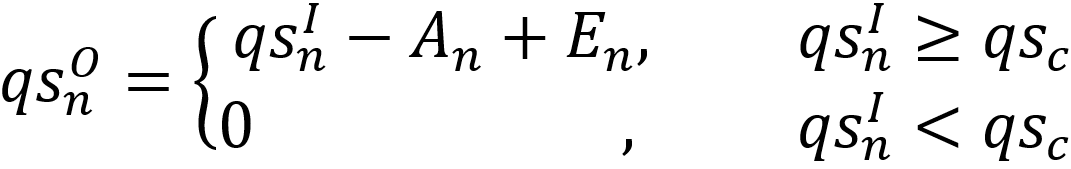
<div>    
  
    
- MWR uses a set of rules and algorithms to numercally represent the release of the mass wasting source material, erosion, deposition and the impact of vegetation/debris on the runout process as illustrated below:

<div>
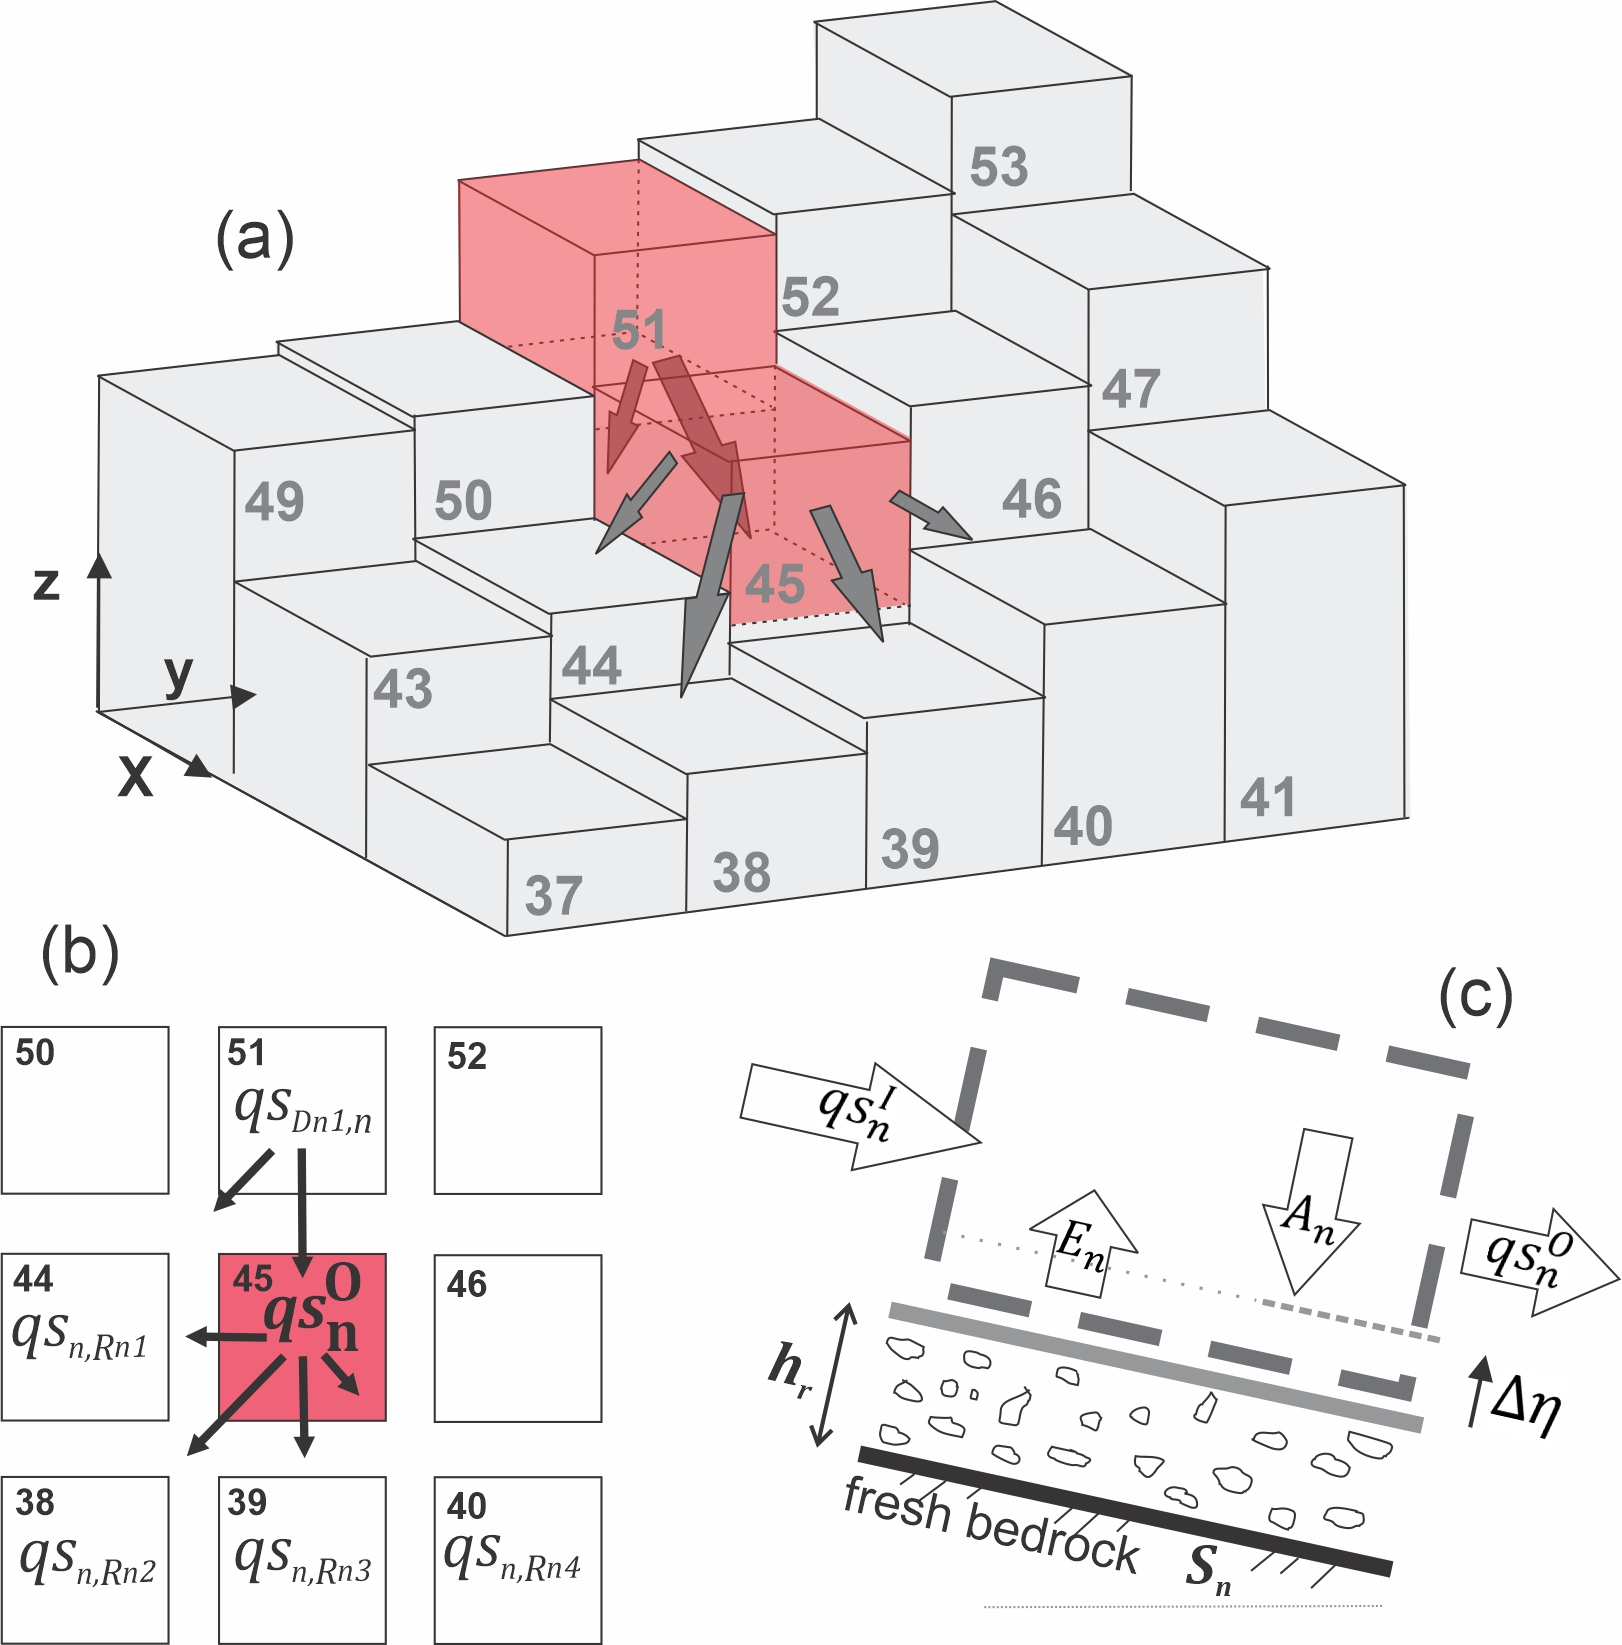
<div>

<strong><em>(a)</em></strong> Release of the initial mass wasting source material nodes (represented by red cells) <strong><em>(b)</em></strong> How qsO_n is distributed downslope after incoming material qsI_n (here equal to qs_Dn1,n) has aggraded (A_n) or eroded (E_n). node n <strong><em>(c)</em></strong> Mass continuity determines the change in regolith/topographic surface. For a full description of the above parameters, see Keck et al. (2024) 

#### First import  packages and components necessary to run MWR and visualize results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

from landlab.components import (FlowAccumulator, 
                                DepressionFinderAndRouter,
                                FlowDirectorD8, 
                                FlowDirectorMFD)
from landlab import imshow_grid_at_node
from landlab.io import read_esri_ascii
from landlab.components.mass_wasting_router import MassWastingRunout

#### Next, define key MWR parameters S_c, qs_c and k and attributes to be tracked by the model.<br>
In MWR, S_c is a critical slope constraint. For some flows, S_c can be approximated from the surface slope of observed deposits. The parameter qs_c is the threshold flux for deposition, that conceptually represents the flow depth below which flow resistance is large enough to cease the forward momentum of the flow, whether in the form of frictional resistance along the base of the flow or debris and vegetation in the path of the flow. Parameter k scales the erosion rate.<br>

As described in Keck et al. (2024), calibration may be required to determine a single S_c and qs_c value to parameterizes MWR to a site while other model parameters can be determined directly from a site. 

In [2]:
# Model parameters, determined through calibration 
S_c = [0.15589918235700001]
qs_c = 0.766

# Model parameters, determined from field and DEM of Difference
k = 0.0337443
typical_flow_thickness_of_erosion_zone = 2
typical_slope_of_erosion_zone = 0.25
max_flow_depth_observed_in_field = 5

# regolith and runout material attributes that will be tracked
tracked_attributes = ['particle__diameter']

#### Now, define a few functions needed for defining model domain and plotting model results.<br>
These functions are only included in this notebook for visualizing the modeled output and are not necessary to run the model.

In [3]:
# plotting functions
def plot_node_field_with_shaded_high_res_dem(mg, mg_hs, field, save_name= None, plot_name = None, figsize = (7,7), 
                                    cmap = 'terrain', fontsize = 10,alpha = 0.5, cbr = None, norm = None, allow_colorbar = True, colorbar_label =None,
                                    var_name = None, var_units = None, domain_buffer = 0, **kwds):

    if plot_name is None:
        plt.figure(field,figsize= figsize)
    else:
        plt.figure(plot_name,figsize= figsize) 
    
    d = imshow_grid_at_node(mg_hs, 'hillshade_arc', cmap='Greys_r',
                      grid_units=('coordinates', 'coordinates'),
                      shrink=0.75, var_name=None, var_units=None,output=None,allow_colorbar=False,
                      color_for_background = 'white', color_for_closed= 'white', limits = (0,360))
    fig = imshow_grid_at_node(mg, field, cmap= cmap,
                      grid_units=('coordinates', 'coordinates'),
                      shrink=0.75, var_name=var_name, var_units=var_units,alpha = alpha,output=None,
                      color_for_closed= None, color_for_background = None,
                      norm = norm,allow_colorbar=allow_colorbar,colorbar_label = colorbar_label)
    
    plt.xlim([mg.x_of_node[mg.core_nodes].min()-20, mg.x_of_node[mg.core_nodes].max()+domain_buffer])
    plt.ylim([mg.y_of_node[mg.core_nodes].min()-20, mg.y_of_node[mg.core_nodes].max()+domain_buffer])
    
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    if cbr is None:
        r_values = mg.at_node[field][mg.core_nodes]
        plt.clim(r_values.min(), r_values.max())
    else:
        plt.clim(cbr[0], cbr[1])
        
    if save_name is not None:
        plt.savefig(save_name+'.png', dpi = 300, bbox_inches='tight')



def get_values_xy(grid, field):
    # convert grid array to input for pcolormesh (from imshow_grid)
    values = grid.at_node[field]
    values = values.reshape(grid.shape)
    y = (
        np.arange(values.shape[0] + 1) * grid.dy
        - grid.dy * 0.5
        + grid.xy_of_lower_left[1]
    )
    x = (
        np.arange(values.shape[1] + 1) * grid.dx
        - grid.dx * 0.5
        + grid.xy_of_lower_left[0]
    )
    return x, y, values

# plotting function
def color_mesh_vals(clim = [-1,1]):
    x,y,values = get_values_xy(mg, 'dem_dif_m')
    myimage = plt.pcolormesh(x, y, values, cmap = 'bwr', alpha = 0.5)
    myimage.set_rasterized(True)
    myimage.axes.set_aspect("equal")
    plt.autoscale(tight=True)    
    plt.clim(clim)
    return myimage

#### Next, load GIS inputs onto the grid, including the landslide polygon.<br>
To initiate MWR, the user needs to provide an initial DEM, a regolith depth map and the location and depth of the mass wasting source material (e.g., landslide body).<br>
In this example, the required inputs have been prepared using an external GIS system. The number of rows and columns and grid size (10 meter) of each input is the same. Below we load each and add them as fields to a raster model grid.

In [4]:
#%% load GIS inputs
# GIS generated inputs
DEM_pre = 'pre_runout_DEM.asc' 
DEM_pre_hs = 'pre_runout_DEM_hillshade.asc' # high (2-meter resolution)
lsnodes = 'landslide_polygon.asc'# nodes within the mapped landslide
DoDo = 'DEM_of_Difference.asc'# observed DEM of difference
ls_thickness = 'landslide_thickness.asc' # measured thickness at each node

# dem
mg, z = read_esri_ascii(DEM_pre, name='topographic__elevation')

# ls nodes
_, mw1 = read_esri_ascii(lsnodes, name='mass__wasting_id')
mg.add_field('node', 'mass__wasting_id',mw1.astype(int))

# observed DoD
_, mw1 = read_esri_ascii(DoDo, name='dem_dif_o')
mg.add_field('node', 'dem_dif_o',mw1)
mg.at_node['dem_dif_o'][mg.at_node['dem_dif_o'] == -9999] = 0 # change null values to zero

# create a modeled DoD field, to be updated later to show animation of modeled DoD
mg.at_node['dem_dif_m'] = np.zeros(mg.number_of_nodes) # 

# soil depth
depth = np.ones(mg.at_node['topographic__elevation'].shape[0])*1.2 # here using uniform depth of 1.2 meters
mg.add_field('node', 'soil__thickness',depth)

# set landslide thickness (depth) equal to measured depth from DEM of Difference
lsdepth = 'sd_s1000_v5_10m.asc' 
_, lsd = read_esri_ascii(lsdepth, name='ls_depth')
lsd = lsd[lsd != -9999]
mg.at_node['soil__thickness'][mg.at_node['mass__wasting_id'] == 1] = -1*lsd

# high res hillshade for plot background
mg_hs, hs = read_esri_ascii(DEM_pre_hs, name='hillshade')
mg_hs.at_node['hillshade_arc'] = hs
mg_hs.at_node['hillshade_arc'][mg_hs.at_node['hillshade_arc'] == -9999] = np.nan

mg.set_watershed_boundary_condition(z) # finds lowest point in dem and sets it as an open node

# add particle diameter
mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*0.316 # representative grain size of regolith

# flow accumulater to get contributing area to each grid cell. We initially use the FlowDirectorD8 option 
# to visualize topographic slope but will replace the flow router with the MFD option later in this notebook
# because MWR uses the multi-directional slope.
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()

# fill depressions to correct surface area determination
df_4 = DepressionFinderAndRouter(mg)
df_4.map_depressions()

# save an copy of the initial elevation for dem differencing
_ = mg.add_field('topographic__initial_elevation',
                    mg.at_node['topographic__elevation'],
                    at='node',
                    copy = True)

#### Before we instantiate and run the model, lets visualize some of the loaded inputs to understand the landslide and terrain it flowed down

The landslide body formed along the edge of a scarp left by a previous landslide and is an enlargment of an existing landslide. Downslope of the landslide, a first to second order channel drains the center of the hillslope and two forest roads cross the channel. Both road crossing are large fills that effectively create check dams for the landslide once it runs out.

Below, you see the mapped landslide, represented by the nodes (shown as dark cells) within the mapped landslide polygon

<Figure size 640x480 with 0 Axes>

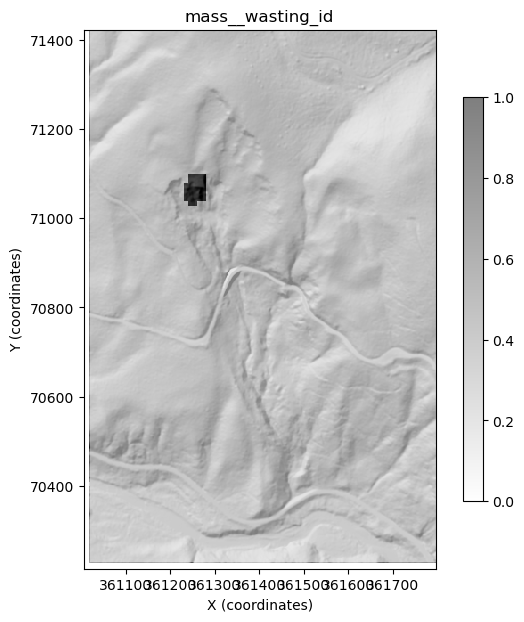

In [5]:
%matplotlib inline 
plt.figure()
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'mass__wasting_id',cmap = 'binary', cbr = [0,1])

In the next figure, slope is shown. You can see that there is an area of moderate to low slope (green and blue cells) between the two roads

<Figure size 640x480 with 0 Axes>

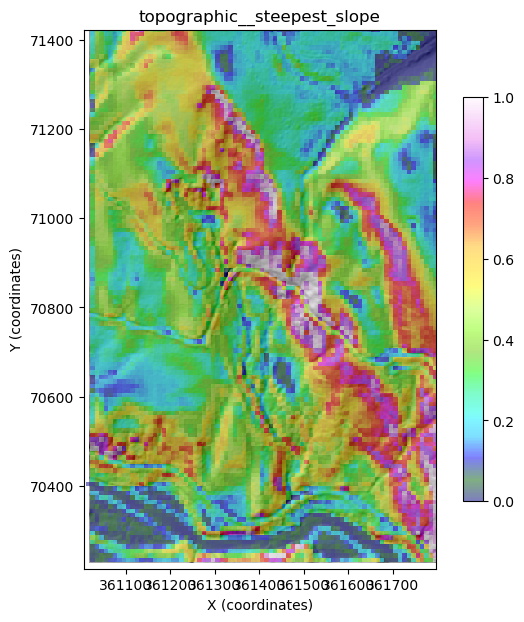

In [6]:
%matplotlib inline
plt.figure()
plot_node_field_with_shaded_high_res_dem(mg=mg, mg_hs = mg_hs, field = 'topographic__steepest_slope',cmap = 'gist_ncar',cbr = [0,1])
plt.show()

Below, you see the DEM of Difference (red - aggradation, blue - erosion) of the observed runout. Notice how the observed runout is generally confined to the channel, erodes along the steep reaches and deposits in the moderate to low slope reaches. The observed runout alls forms thick deposits upchannel of the road crossings.

<Figure size 640x480 with 0 Axes>

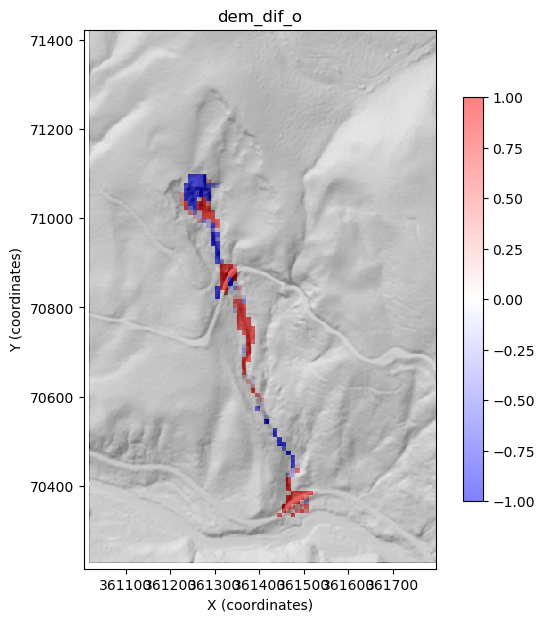

In [7]:
%matplotlib inline
plt.figure()
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'dem_dif_o',cmap = 'bwr', alpha = 0.5,cbr = [-1,1])
plt.show()

#### Now set up an instance of MWR using the newly defined raster model grid and the landslide and run the model! <br>
Before we instantiate the model, we need to switch the topographic__steepest_slope and other related flow routing fields from the D8 flow routing option to the multidirectional routing option. MWR uses multi-directional slope. 

In [8]:
# multiflow direction for MWRu
# need to delete d8 flow direction
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')

# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'slope')
fd.run_one_step()

# set model parameters
MWR = MassWastingRunout(grid = mg,
                        critical_slope = S_c,
                        threshold_flux = qs_c,
                        erosion_coefficient = k,      
                        tracked_attributes = tracked_attributes,
                        save = True,
                        typical_flow_thickness_of_erosion_zone = typical_flow_thickness_of_erosion_zone,
                        typical_slope_of_erosion_zone = typical_slope_of_erosion_zone,
                        max_flow_depth_observed_in_field = max_flow_depth_observed_in_field
                       )

MWR.run_one_step()

 running with spatially variable Dp 


#### Once the model has finished running, view runout extent and how topography changed. <br>

<IPython.core.display.Javascript object>


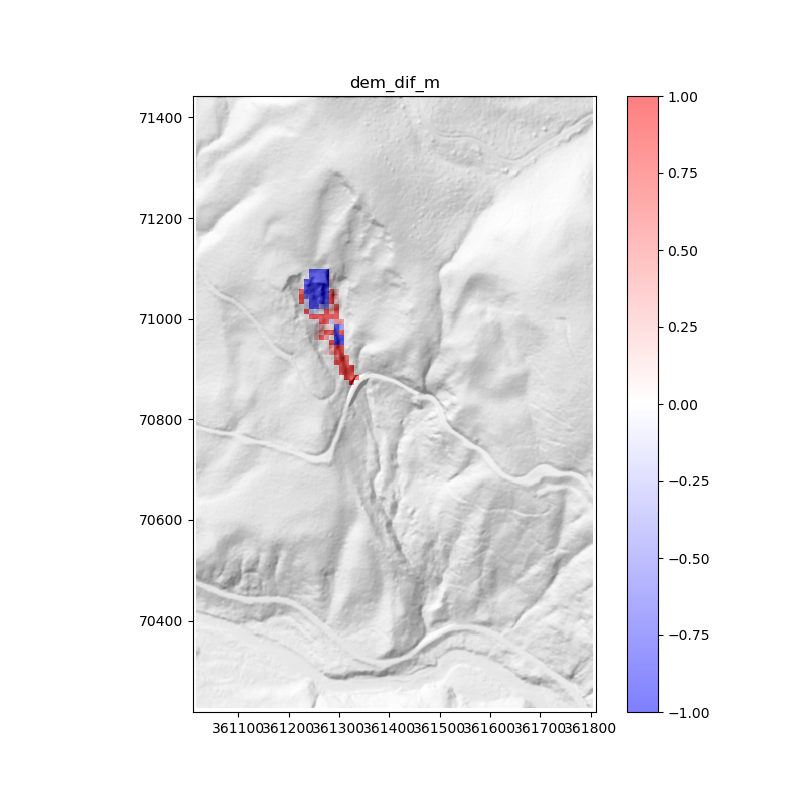

In [9]:
import gc
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

%matplotlib notebook


# update function
def update_plot(frame_number, MWR, plot):
    mg.at_node['dem_dif_m'] = MWR.saver.runout_evo_maps[0][frame_number]-mg.at_node['topographic__initial_elevation']
    plot[0].set_array(mg.at_node['dem_dif_m'])
    plot[0].remove()
    plot[0] = color_mesh_vals(clim = [-1,1])

# prepare the first frame
fig = plt.figure(figsize = (8,8))
nmax=len(MWR.saver.runout_evo_maps[0].keys())
x,y,values = get_values_xy(mg_hs, 'hillshade_arc')
myimage = plt.pcolormesh(x, y, values, cmap = 'Greys_r', alpha = 1)
myimage.set_rasterized(True)
myimage.axes.set_aspect("equal")
plt.autoscale(tight=True)
plot = [color_mesh_vals(clim = [-1,1])]
plt.title('dem_dif_m')
cb = plt.colorbar(norm=True)


animate_10 = animation.FuncAnimation(fig, update_plot, nmax, 
                                     fargs=(MWR, plot),
                                     blit = True, repeat = True, 
                                     cache_frame_data=False)

Here the terrain is now colored according to the modeled DEM of Difference. Notice how the landslide removed material at its source and deposits shortly downslope. It then erodes through a steep, narrow reach until it reaches the first road crossing, where it deposits again. After flowing over the road, it partially erodes the road surface. Below the first road surface, it spreads and deposits on the moderate to lower sloped part of the hillslope before being funneled into another narrow, steep reach. Finally, it intersects the lower road crossing, where it fills the area uplsope of the crossing before flowing over the road and down into the river valley below.

#### Try re-running this notebook with different parameter values to see if you can cause a larger deposit in the river valley below the second road crossing!